# QLanczos

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
from scipy.linalg import eigh
from scipy.linalg import eig
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
# import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

Calculate normalization coefficients using recurrence in 

In [2]:
def normalization_coefficient(ncoefs,Ccoefs,r):
    """
    Compute the rth normalization coefficient via recurrence
    """
    nr=ncoefs[r-1]
    Cr=Ccoefs[r-1]
    return nr/np.sqrt(Cr)

def normalization_coefficients(Ccoef):
    """
    Compute normalization coefficients from overlaps 
    """
    ncoefs=np.zeros(len(Ccoef))
    ncoefs[0]=1/np.sqrt(Ccoef[0])
    for r in range(1,len(Ccoef)):
        ncoefs[r]=normalization_coefficient(ncoefs,Ccoef,r)
    
    return ncoefs


QLanczos 

In [3]:
def Krylov_matrices(krylov_indices,ncoefs,energies,threshold=1e-2):
    dim=len(krylov_indices)
    
    ## Construct overlap matrix
    T=np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            l=krylov_indices[j]
            lp=krylov_indices[i]
            k=int((l+lp)/2)
            T[i,j]=(ncoefs[l]*ncoefs[lp])/(ncoefs[k]**2)

    ## Elimiate small eigenvalues form overlap matrix
    eigs,evecs=eig(T)
    D=np.zeros((dim,dim))
    for i in range(dim):
        if abs(eigs[i].real)>threshold:
            D[i,i]=eigs[i]
            
    T=np.dot(evecs.transpose(),np.dot(D,evecs))  
            
    ## Construct H matrix 
    H=np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(0,dim):
            l=krylov_indices[j]
            lp=krylov_indices[i]
            k=int((l+lp)/2)
            H[i,j]=T[i,j]*energies[k]
            
    return T,H



def run_qlanczos_experiment(H,krylov_dim,delta_time,backend,initialization,max_iterations=100,krylov_threshold=.99999,A_threshold=1e-10,cstep=None):
    """
    Run qite evolution to get energies of ground state 
    """

    n_qubits=H.N_qubits
    n_shots=10000 ## Set to allowed number of shots at IBMQ

    ## Get list of sigmas (all pauli terms with odd number Y gates)
    sigmas=sigma_terms(n_qubits)

    ## Construct b in terms of paulis 
    b_pauli_terms=b_terms(H,sigmas)
    
    ## Construct S in terms of paulis
    S_pauli_terms=S_terms(sigmas)

    ## Get composite set of pauli terms that need to be calculated for QITE 
    pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

    ## Get commuting set 
    commuting_sets=get_commuting_sets(sorted(pauli_set))
    
    ## Zero initialize 
    A_set=[]
    a=np.zeros(len(sigmas))
    Energies=[]
    Ccoefs=[]
    ncoefs=[]
    
    ## for each time step, run circuit and compute A for the next time step
    krylov_indices=[0]
    t=0
    while len(krylov_indices)<krylov_dim:
        if t>max_iterations:
            break
        expectation_values={}
        if backend=='statevector_simulator':
            ## Run circuit to get state vector
            psi=run_circuit_statevector(n_qubits,A_set,delta_time,initialization=None)

            ## Compute expectation value for each pauli term 
            for pauli_id in commuting_sets:        
                for pauli in commuting_sets[pauli_id]: 
                    pauli_mat = get_pauli_matrix(pauli)
                    e_value=np.conj(psi).T @ pauli_mat @ psi
                    expectation_values[pauli]=e_value

        else:
            for pauli_id in commuting_sets:   
                ## Run circuit to get counts 
                meas_results=run_circuit_qasm(n_qubits,A_set,pauli_id,delta_time,n_shots=n_shots,initialization=None)

                ## Compute expectation value for each pauli term 
                for pauli in commuting_sets[pauli_id]: 
                    expectation_values[pauli]=compute_expectation_value(pauli,meas_results)    


        ## Compute energy
        H_pauli=H.pauli_coeffs
        energy=0.0
        for key in H_pauli:
            energy+=H_pauli[key]*expectation_values[key]

        Energies.append(energy.real)

        ## compute normalization coef C=1-2*E*delta_times
        Ccoef=1-2*delta_time*Energies[t]
        Ccoefs.append(Ccoef)
        
        ## Compute A
        A_set.append(A_pauli_operator(delta_time,sigmas,S_pauli_terms,b_pauli_terms,expectation_values,Ccoef,A_threshold))

        if isinstance(cstep,int):
            if t%cstep==0:
                identity_string="I"*n_qubits
                A_combine=WeightedPauliOperator([(0.0,Pauli.from_label(identity_string))])
                for A in A_set:
                    A_combine+=A
                A_set=[A_combine]
         
        ### Compute normalization factor 
        if t==0:
            ncoefs.append(1.0)
        else:
            ncoefs.append(normalization_coefficient(ncoefs,Ccoefs,t))
            
            ## If even time step, check overlap
            if t%2==0:        
                i=t
                j=krylov_indices[-1]
                k=int((i+j)/2)
                regularization_factor=(ncoefs[i]*ncoefs[j])/(ncoefs[k]**2)
                if regularization_factor<krylov_threshold:
                    krylov_indices.append(i)
        
        ### increment t
        t+=1    

    ## Construct krylove matries 
    T_krylov,H_krylov=Krylov_matrices(krylov_indices,ncoefs,Energies,threshold=1e-1)

    ## Solve generalized eigenproblem
    eigs,vecs=eig(H_krylov,T_krylov)
    idx = eigs.argsort()[0]
    print(idx)
    print(f"Iterations: {t-1}")
    print(f"Krylov dim: {len(krylov_indices)}")
    return eigs[idx].real



In [4]:
H = hamiltonian_matrix(Nmax=6,J=1,interaction="toy")
exact_eigenvalue,_=eigh(H)

H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(f"N qubits: {n_qubits}")

initialization="single_state"
backend = 'statevector_simulator'

# krylov_dim=8
# kthreshold=.998

krylov_dim=7
kthreshold=.999

max_itr=100
delta_time=0.01
QL_energy=run_qlanczos_experiment(H_qubit,krylov_dim,delta_time,backend,initialization,max_iterations=max_itr,krylov_threshold=kthreshold,A_threshold=1e-10,cstep=1)
# print(QL_energies)

N qubits: 2
0
Iterations: 20
Krylov dim: 7


In [6]:
num_iterations=20
Qite_energies=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=1)
print(f"Exact eigenvalue: {exact_eigenvalue[0]:0.6}")
print(f"Qite eigenvalue: {Qite_energies[-1]:0.6}")
print(f"QLancozs eigenvalue: {QL_energy:0.6}")

100%|██████████| 20/20 [00:00<00:00, 75.56it/s]

Exact eigenvalue: -2.14398
Qite eigenvalue: -2.08738
QLancozs eigenvalue: -2.14395


In [10]:
Nmax=6
H = hamiltonian_matrix(Nmax,J=1,interaction="toy")
exact_eigenvalue,_=eigh(H)

H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(f"N qubits: {n_qubits}")

initialization="zeros"
backend = 'qasm_simulator'

# krylov_dim=8
# kthreshold=.998

krylov_dim=7
kthreshold=.997

max_itr=100
delta_time=0.01
QL_energy=run_qlanczos_experiment(H_qubit,krylov_dim,delta_time,backend,initialization,max_iterations=max_itr,krylov_threshold=kthreshold,A_threshold=1e-2,cstep=1)
print(QL_energy)

N qubits: 2
0
Iterations: 68
Krylov dim: 7
-2.6559832790621827


In [11]:
num_iterations=68
Qite_energies=run_qite_experiment(H_qubit,num_iterations,delta_time,backend,initialization,A_threshold=1e-2,cstep=1)
print(f"Exact eigenvalue: {exact_eigenvalue[0]:0.6}")
print(f"Qite eigenvalue: {Qite_energies[-1]:0.6}")
print(f"QLancozs eigenvalue: {QL_energy:0.6}")

100%|██████████| 68/68 [00:11<00:00,  5.71it/s]

Exact eigenvalue: -2.14398
Qite eigenvalue: -2.02995
QLancozs eigenvalue: -2.65598


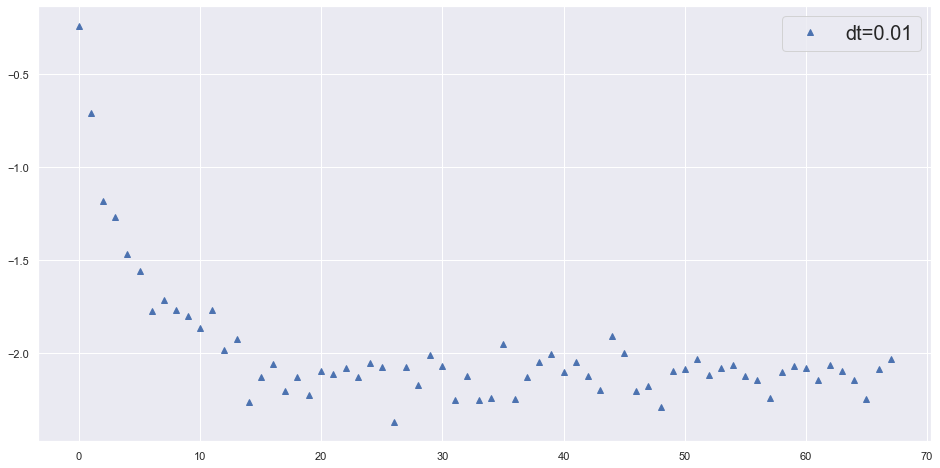

In [12]:
time=[t for t in range(num_iterations)]
plt.plot(time,Qite_energies,'b^',label="dt=0.01")
plt.legend(prop={'size': 20})